#### Import Libraries

In [1]:
import sys
sys.path.append('/Users/w5b0h0/Desktop/gradient normalization/gradient normalization')

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from algorithms import FedAvg, SCAFFOLD
# from utils.util import create_fresh_models
from utils import Client, Server, create_fresh_models, plot_accuracy_comparison, plot_loss_comparison
from model import LogisticRegressionBinary, MLP, ResNet, resnet18
from data import split_doubly_stochastic_direct, get_mnist_dataset, get_cifar10_dataset, get_mnist_binary_dataset, split_dirichlet
from torchvision import datasets, transforms


Input shape: torch.Size([32, 3, 32, 32])
Output shape: torch.Size([32, 10])


#### Obtain Heterogeneous Data

In [2]:
train_dataset, test_dataset = get_mnist_dataset()

num_clients = 10
num_classes = 10
alpha1 = 0.1
alpha2 = 10


dataset_list1, client_distribution1 = split_dirichlet(train_dataset, alpha1, num_clients, num_classes)
dataset_list2, client_distribution2 = split_dirichlet(train_dataset, alpha2, num_clients, num_classes )
dataset_list3, client_distribution3 = split_doubly_stochastic_direct(train_dataset, alpha1, num_clients, num_classes)
dataset_list4, client_distribution4 = split_doubly_stochastic_direct(train_dataset, alpha2, num_clients, num_classes)


batch_size = 4

client_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
server_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)



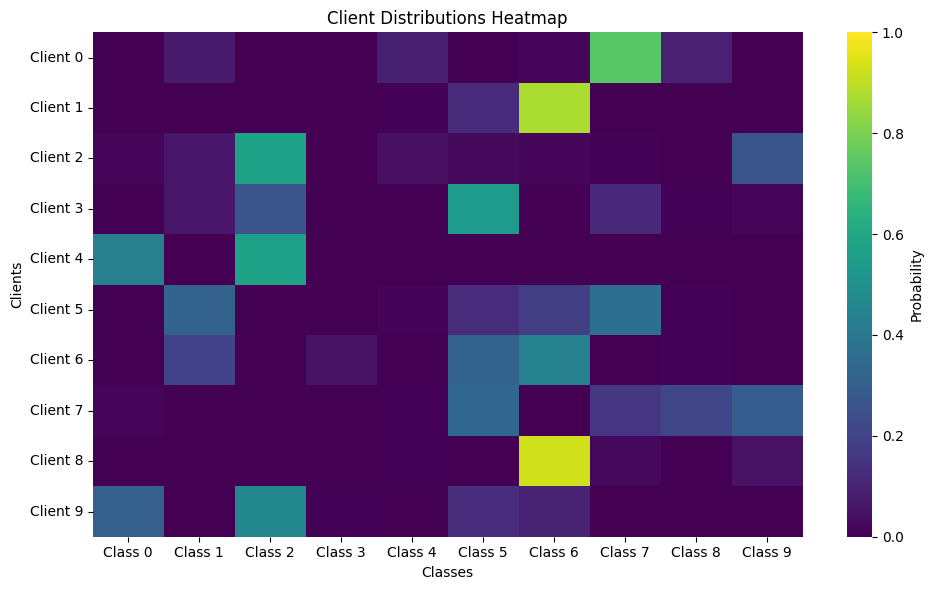

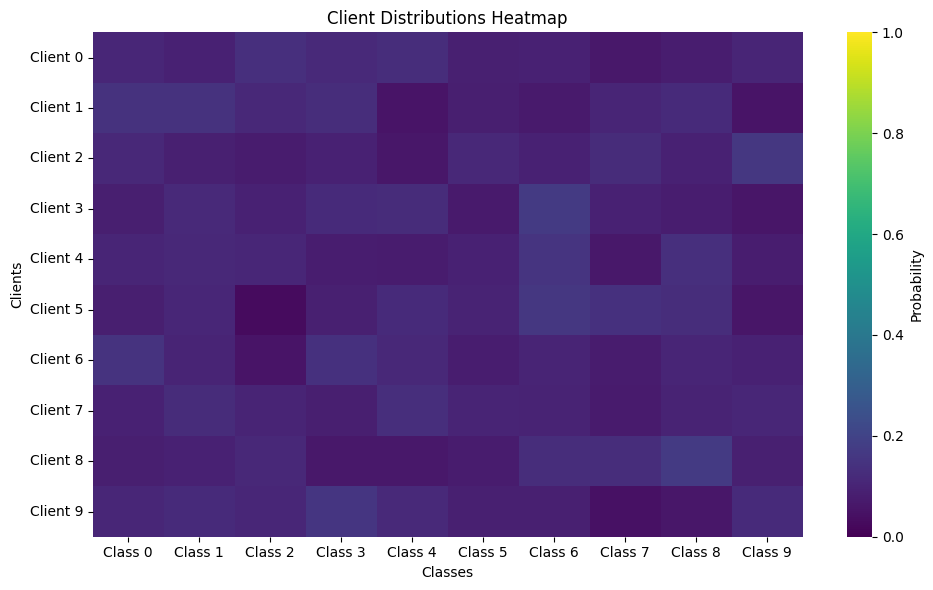

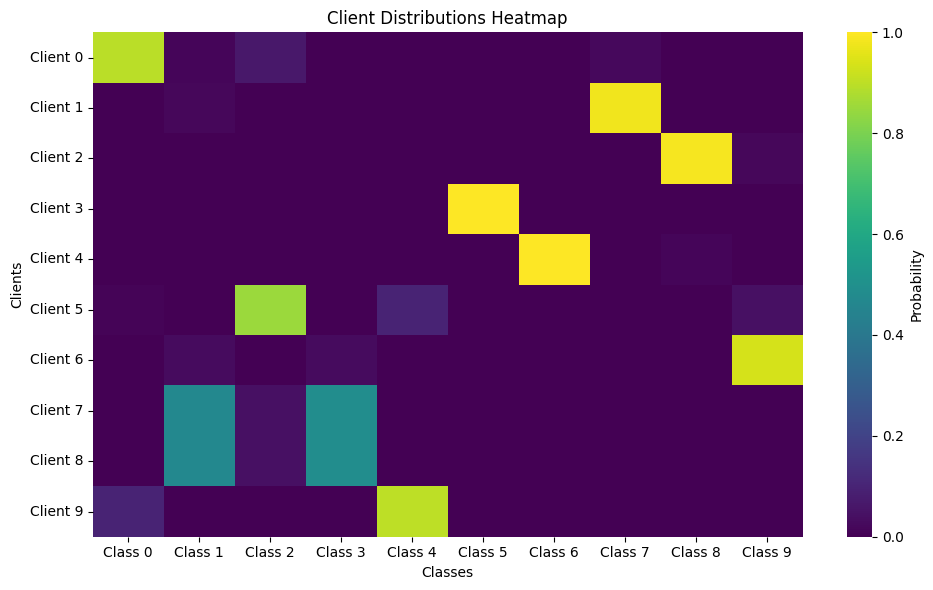

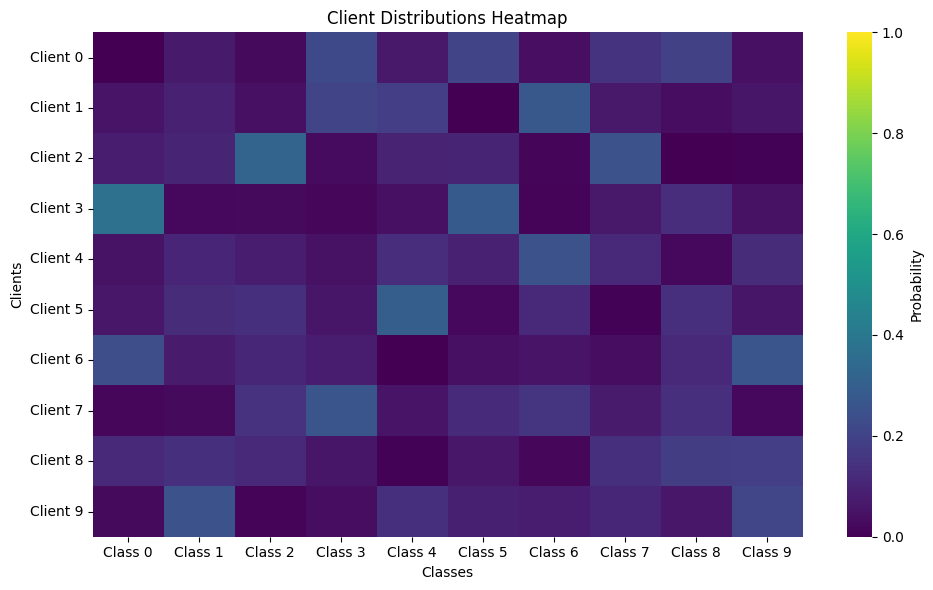

array([[0.00316618, 0.06743759, 0.02455145, 0.22193973, 0.06507369,
        0.20155384, 0.03681753, 0.14466506, 0.19449492, 0.04030009],
       [0.05348856, 0.0912925 , 0.0424828 , 0.20297457, 0.18052283,
        0.00290047, 0.2734116 , 0.06446465, 0.03279772, 0.05566436],
       [0.07763489, 0.09910074, 0.31913593, 0.02996895, 0.09383053,
        0.10110275, 0.01559468, 0.25265926, 0.00332818, 0.00764412],
       [0.3683404 , 0.02341401, 0.02698594, 0.01563053, 0.04053156,
        0.27873954, 0.00998587, 0.06406705, 0.1263817 , 0.04592329],
       [0.04774829, 0.10351112, 0.07788847, 0.04614887, 0.12881745,
        0.0900367 , 0.25256288, 0.11101855, 0.02099837, 0.1212694 ],
       [0.05881304, 0.12476444, 0.13847876, 0.0571016 , 0.29332954,
        0.02018605, 0.10968507, 0.00722056, 0.13473698, 0.055684  ],
       [0.23714216, 0.07328534, 0.10836297, 0.07813323, 0.00100191,
        0.04199349, 0.05166024, 0.03408404, 0.11393104, 0.26040548],
       [0.01921557, 0.02501231, 0.1417468

In [3]:
from utils import visualize_client_distributions

visualize_client_distributions(client_distribution1)

visualize_client_distributions(client_distribution2)

visualize_client_distributions(client_distribution3)

visualize_client_distributions(client_distribution4)


#### Experimental Algorithm and Parameter Settings

In [ ]:
theta = 0.9
iteration = 81
criterion = torch.nn.CrossEntropyLoss()
inner_iter = 1
gamma = 0.05
inner_lr = 0.01
algorithms_to_test = ["FedAvg", "FedAvg-GN"]

loss_results = {}
acc_results = {}
grad_norm_results = {}


gamma1=0.1
inner_lr1=0.1
for algo_name in algorithms_to_test:
    if algo_name in ["FedAvg-GN","FedAvg-GN-M"]:
        gamma=gamma1
        inner_lr=inner_lr1
        
    else:
        gamma=gamma1
        inner_lr=inner_lr1
    
    clients, server = create_fresh_models("MLP", dataset_list3, train_dataloader, test_dataloader, 
                                          batch_size, num_classes, inner_lr, client_device, server_device, algo_name, theta)
    
        
    # if algo_name not in ["FedAvg-GN-M"]:
    #     continue
    if algo_name == "SCAFFOLD":
        algorithm = SCAFFOLD(clients, server)
        loss, acc = algorithm.scaffold(iteration, criterion, gamma, inner_iter)
    else:
        # continue
        algorithm = FedAvg(clients, server, theta, algo_name)
        loss, acc, grad_norm = algorithm.fedavg(iteration, criterion, gamma, inner_iter)

    loss_results[algo_name] = loss
    acc_results[algo_name] = acc
    if algo_name in ["FedAvg-GN-M"]:
        grad_norm_results[algo_name] = grad_norm


FedAvg 0.0


Round 0: Loss = 7.5364, Accuracy = 9.80%
Loss: 2.517817974090576
cal gradtensor([-0.0797, -0.0797, -0.0797,  ...,  0.0274,  0.0195,  0.0663],
       device='cuda:0')
true grad tensor([-0.0797, -0.0797, -0.0797,  ...,  0.0274,  0.0195,  0.0663],
       device='cuda:0')
Round 0: Loss = 6.2372, Accuracy = 10.28%
Loss: 3.793369770050049
cal gradtensor([-0.0287, -0.0287, -0.0287,  ..., -0.9732,  0.0159,  0.0773],
       device='cuda:0')
true grad tensor([-0.0287, -0.0287, -0.0287,  ..., -0.9732,  0.0159,  0.0773],
       device='cuda:0')
Round 0: Loss = 8.2776, Accuracy = 9.74%
Loss: 4.255660533905029
cal gradtensor([-0.0258, -0.0258, -0.0258,  ...,  0.0349, -0.9829,  0.0804],
       device='cuda:0')
true grad tensor([-0.0258, -0.0258, -0.0258,  ...,  0.0349, -0.9829,  0.0804],
       device='cuda:0')
Round 0: Loss = 9.6200, Accuracy = 8.92%
Loss: 2.3162717819213867
cal gradtensor([0.0327, 0.0327, 0.0327,  ..., 0.0260, 0.0213, 0.0396], device='cuda:0')
true grad tensor([0.0327, 0.0327, 0.03

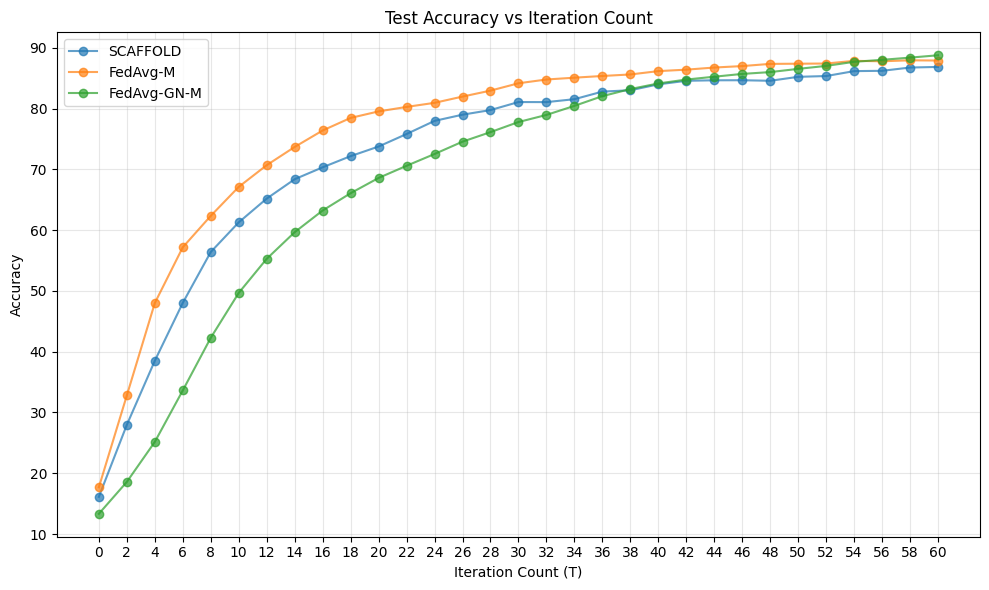

In [ ]:
plot_accuracy_comparison(acc_results)

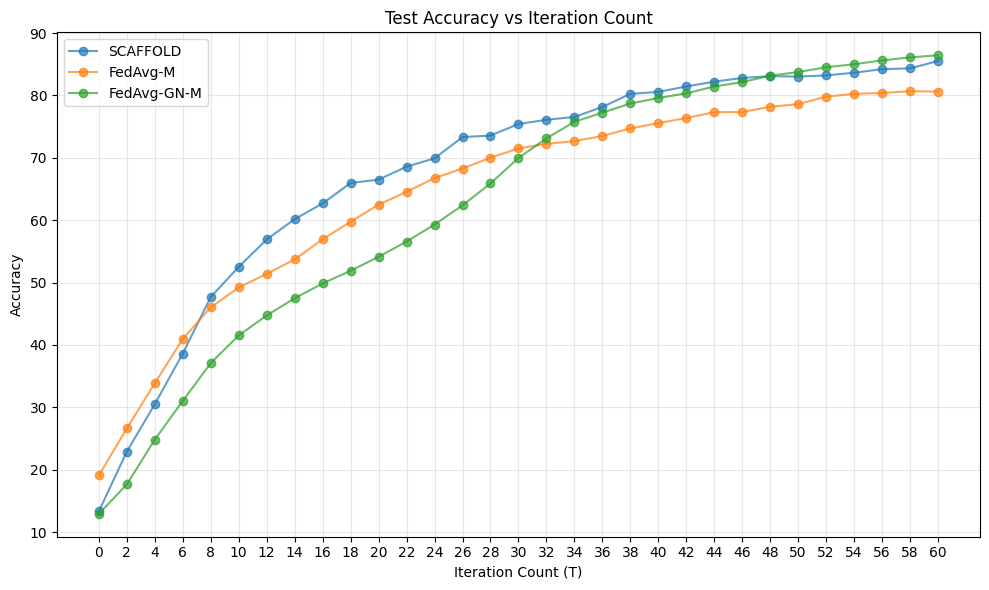

In [ ]:
plot_accuracy_comparison(acc_results)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
figsize=(10, 6)
title='Test Accuracy vs Iteration Count'
acc_results

plt.figure(figsize=figsize)

x = np.arange(0,len(acc_results["EF21-SGDM"])*2,2)
    
plt.plot(x, acc_results["EF21-SGDM"], '-o', label="EF21-SGDM", alpha=0.7)
plt.plot(x, acc_results["QSGD-GN-M u=1"], '-o', label="QSGD-GN-M u=1", alpha=0.7)
plt.plot(np.arange(0,len(acc_results["EF21-SGDM"]),2), acc_results["QSGD-GN-M u=2"][::2], '-o', label="QSGD-GN-M u=2", alpha=0.7)
plt.title(title)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()